# WCPDT Orphan Peptide Analysis
Here we run the analysis to identify orphan transcripts.

In [1]:
from Bio import SeqIO
import pandas as pd
import numpy as np
import re
import os
import json as js
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
#Set figure configurations
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Compile Data

In [2]:
quant_files = [f for f in os.scandir("/flash/jwang/DeRisi/salmon/") if f.name.endswith("quant")]
len(quant_files)

145

In [3]:
tx_sample_dict = {}
no_hits = []
for f in quant_files:
    sample_name = f.name[:-6]
    path = f.path + "/quant.sf"
    quant = pd.read_csv(path, sep="\t")
    if np.sum(quant["TPM"] > 0) == 0:
        no_hits.append(sample_name)
        continue  
    for tx, tpm in zip(quant["Name"], quant["TPM"]):
        if tx in tx_sample_dict:
            tx_sample_dict[tx][sample_name] = tpm
        else:
            tx_sample_dict[tx] = {sample_name : tpm}
len(tx_sample_dict), len(no_hits)

(935948, 0)

### Save Data


In [4]:
with open("results/tx_sample_tpm_dict.json", "w") as out:
    js.dump(tx_sample_dict, out)

# Identify ORFs and Kozak Sequences
Kozak sequence is based on this original 1987 paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC306349/
<br>
The below code was written by Aidan.

In [5]:
"""These were from Aidan's notebook (might want to find the exact paper to verify)
KOZAK_PWM refers to the positioned based percentages of nucleotide appearance. For instance in 
at position -4 (first row) A appears at rate of 25% C at 53% and so on. Note that start codon (ATG) 
is included in this Kozak sequence."""
kozak_pwm = pd.DataFrame({'A' :[25, 61, 27, 15, 97, 1, 1, 23],
                          'C' :[53, 2, 49, 55, 1, 1, 1, 16],
                          'G' :[15, 36, 13, 21, 1, 1, 97, 46],
                          'T' :[ 7, 1, 11, 9, 1, 97, 1, 15]})
#log likelihood: calculated with the probability of a base at a given position divided by 
#              the probability of that base randomly (0.25 since there are 4 bases)
pwm_log = np.log2((kozak_pwm/100)/0.25)
pwm_log

,A,C,G,T
0,0.000000,1.084064,-0.736966,-1.836501
1,1.286881,-3.643856,0.526069,-4.643856
2,0.111031,0.970854,-0.943416,-1.184425
3,-0.736966,1.137504,-0.251539,-1.473931
4,1.956057,-4.643856,-4.643856,-4.643856
5,-4.643856,-4.643856,-4.643856,1.956057
6,-4.643856,-4.643856,1.956057,-4.643856
7,-0.120294,-0.643856,0.879706,-0.736966


In [6]:
def getKozak(read, log_pwm = pwm_log, min_AA=20):
    full_regex = "[ACG][AG][ACGT][ACG]ATG(?:[ATGC]{3})*?(?:TAA|TAG|TGA)" 
    #This pattern removes any base with a frequency of < 10 at that position 
    kozak  = re.compile(full_regex)
    
    scores = []
    seqs = []
    #I eliminated the reversal version, because the transcripts should already be in the stranded form and rev comped if on opposite strand
    #If we want to check the reverse strand, we can reverse the read, but need to add rev comp.
    for m in kozak.finditer(read):
        if (len(m.group()) - 4) >= (min_AA) * 3:
            scores.append(sum([log_pwm.loc[x,m.group()[x]] for x in range(len(log_pwm))]))
            seqs.append(m.group())
    
    return scores, seqs

In [7]:
#identify ORFs within transcripts and get kozak score
#results are saved to a file for downstream analysis
meta_file = "results/orphan_peptide_ORFs_meta.csv"
seq_file = "results/orphan_peptide_ORFs.fa"
with open(meta_file, "w") as meta, open(seq_file, 'w') as fa:
    #Write out header
    meta.write("kozak_id,score,ORFlength,ORFIDinTranscript,totalNumORFinTranscript\n")
    
    for seq_record in SeqIO.parse("WCPDT_data/final_merged_cancer.transcripts.fa", "fasta"):
        if seq_record.id not in tx_sample_dict: #Only check 
            continue
        ks, seqs = getKozak(str(seq_record.seq), pwm_log)
        for k in range(len(ks)):
            name = seq_record.id + '_kozak_' + str(k)
            #This is to split the string with newlines so that the fasta reads are not super long in a line
            split_seq = re.sub("(.{60})", "\\1\n", seqs[k], count=0, flags=re.DOTALL)
            fa.write('>' + name + '\n')
            fa.write(split_seq + '\n')
            meta.write(','.join([name, str(round(ks[k], 3)), str(len(seqs[k]) - 4), str(k), str(len(ks))]) + '\n')

In [8]:
orf_kozak_meta = pd.read_csv("results/orphan_peptide_ORFs_meta.csv", index_col=0)
orf_kozak_meta.head(3)

,score,ORFlength,ORFIDinTranscript,totalNumORFinTranscript
kozak_id,,,,
gene.1.0.1-x2-24_kozak_0,5.490,147,0,1
gene.2.0.2-x0-23_kozak_0,6.079,294,0,2
gene.2.0.2-x0-23_kozak_1,5.610,159,1,2


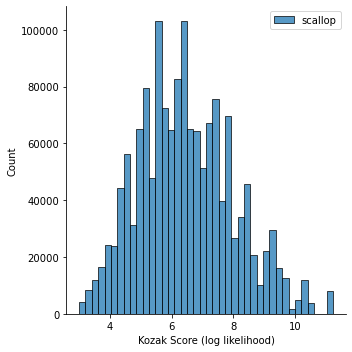

In [9]:
sns.displot(orf_kozak_meta["score"], bins=40, label='scallop')
plt.xlabel('Kozak Score (log likelihood)')
plt.legend()
plt.show()

In [10]:
# Set kozak cutoff score to be the 95th percentile.
kozak_th = np.percentile(orf_kozak_meta["score"], 95) 
kozak_th

9.313

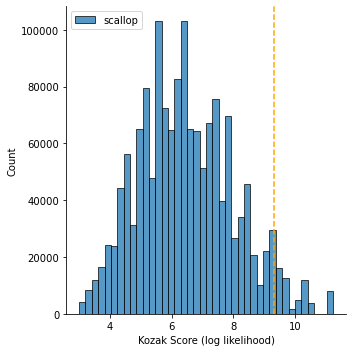

In [11]:
sns.displot(orf_kozak_meta["score"], bins=40, label='scallop')
plt.xlabel('Kozak Score (log likelihood)')
plt.axvline(kozak_th, linestyle='--', c='orange')
plt.legend()
plt.savefig("figures/peptides_kozak_distrib.pdf")
plt.show()

In [12]:
top_kozak_orfs = orf_kozak_meta[(orf_kozak_meta["score"] >= kozak_th)]
print(top_kozak_orfs.shape)
top_kozak_orfs.head(3)

(80758, 4)


,score,ORFlength,ORFIDinTranscript,totalNumORFinTranscript
kozak_id,,,,
gene.7.0.1-x0-30_kozak_0,10.227,153,0,2
gene.17.0.1-x2-3_kozak_0,10.227,153,0,2
gene.5.0.0-x0-3_kozak_0,10.227,153,0,2


# Size Filter
Here we select a threshold for our peptide lengths.

In [13]:
np.min(orf_kozak_meta["ORFlength"])

60

So the minimum ORF length is 60 nt.

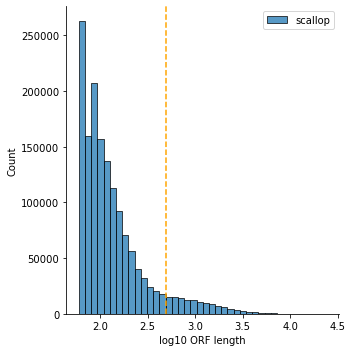

In [14]:
sns.displot(np.log10(orf_kozak_meta["ORFlength"]), bins=40, label='scallop')
plt.xlabel('log10 ORF length')
plt.axvline(np.log10(500), linestyle='--', c='orange')
plt.legend()
plt.savefig("figures/peptides_length_distrib.pdf")
plt.show()

A 500 ORF cutoff makes sense here.

In [15]:
size_filtered_orfs = orf_kozak_meta[orf_kozak_meta["ORFlength"] <= 500]
print(size_filtered_orfs.shape)
size_filtered_orfs.head(3)

(1393669, 4)


,score,ORFlength,ORFIDinTranscript,totalNumORFinTranscript
kozak_id,,,,
gene.1.0.1-x2-24_kozak_0,5.490,147,0,1
gene.2.0.2-x0-23_kozak_0,6.079,294,0,2
gene.2.0.2-x0-23_kozak_1,5.610,159,1,2


# TPM Filter
Here we want to select for peptides that have relatively high expressions levels across the cancer samples.

In [16]:
transcripts = []
median_exp = []
mean_exp = []
for tx, sample_dict in tx_sample_dict.items():
    tpm_array = []
    for sample, tpm in sample_dict.items():
        tpm_array.append(tpm)
    assert len(tpm_array) == 145
    transcripts.append(tx)
    median_exp.append(np.median(tpm_array))
    mean_exp.append(np.mean(tpm_array))
    
tx_exp_df = pd.DataFrame({"tx":transcripts, "median_tpm": median_exp, "mean_tpm":mean_exp})

In [17]:
non_zero_median = tx_exp_df[tx_exp_df["median_tpm"] > 0]
non_zero_median.head(3)

,tx,median_tpm,mean_tpm
1,gene.2.2.0-x0-11,0.087538,0.163984
2,gene.1.0.1-x2-24,1.015092,1.143669
3,gene.2.0.2-x0-23,1.906066,2.253746


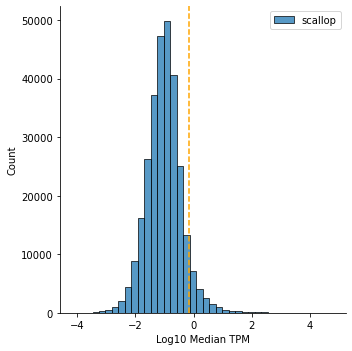

In [18]:
sns.displot(np.log10(non_zero_median["median_tpm"]), bins=40, label='scallop')
plt.xlabel('Log10 Median TPM')
plt.axvline(np.log10(0.7), linestyle='--', c='orange')
plt.legend()
plt.savefig("figures/peptides_median_tpm_distrib.pdf")
plt.show()

In [19]:
non_zero_mean = tx_exp_df[tx_exp_df["mean_tpm"] > 0]

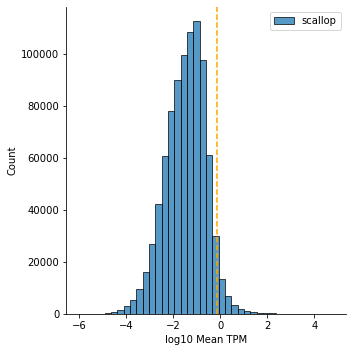

In [20]:
sns.displot(np.log10(non_zero_mean["mean_tpm"]), bins=40, label='scallop')
plt.xlabel('log10 Mean TPM')
plt.axvline(np.log10(0.7), linestyle='--', c='orange')
plt.legend()
plt.savefig("figures/peptides_mean_tpm_distrib.pdf")
plt.show()

In [21]:
median_filtered_orfs = tx_exp_df[tx_exp_df["median_tpm"] > 0.7]
median_filtered_orfs.shape

(19238, 3)

# Filtered List
We require our ORFS to pass all of our filters.

In [22]:
match = [_id for _id in size_filtered_orfs.index if _id in top_kozak_orfs.index]
filtered_orfs = size_filtered_orfs.loc[match]
filtered_orfs["tx"] = [_id.split("_")[0] for _id in filtered_orfs.index]
filtered_orfs["kozak_id"] = filtered_orfs.index
print(filtered_orfs.shape)
filtered_orfs.head(3)

(66933, 6)


,score,ORFlength,ORFIDinTranscript,totalNumORFinTranscript,tx,kozak_id
kozak_id,,,,,,
gene.7.0.1-x0-30_kozak_0,10.227,153,0,2,gene.7.0.1-x0-30,gene.7.0.1-x0-30_kozak_0
gene.17.0.1-x2-3_kozak_0,10.227,153,0,2,gene.17.0.1-x2-3,gene.17.0.1-x2-3_kozak_0
gene.5.0.0-x0-3_kozak_0,10.227,153,0,2,gene.5.0.0-x0-3,gene.5.0.0-x0-3_kozak_0


In [23]:
filtered_orfs = pd.merge(filtered_orfs, median_filtered_orfs, on="tx", how="inner")
print(filtered_orfs.shape)
filtered_orfs.head(3)

(1427, 8)


,score,ORFlength,ORFIDinTranscript,totalNumORFinTranscript,tx,kozak_id,median_tpm,mean_tpm
0,9.611,69,0,3,gene.57.0.1-x2-14,gene.57.0.1-x2-14_kozak_0,2.326552,2.808074
1,10.466,342,0,1,gene.29.1159.6-x1-23,gene.29.1159.6-x1-23_kozak_0,1.971496,2.502299
2,10.466,165,0,3,gene.81.2.2-x0-1,gene.81.2.2-x0-1_kozak_0,2.378656,3.104456


In [24]:
filtered_orfs_id = set(filtered_orfs["kozak_id"])

In [28]:
#Save Files
with open("results/filtered_orphan_peptide_ORFs.fa", "w") as out:
    for record in SeqIO.parse("results/orphan_peptide_ORFs.fa", "fasta"):
        if record.id not in filtered_orfs_id:
            continue
        peptide = str(record.seq[4:].translate()) #This is to offset the 4 nucleotides from the Kozak sequence.
        split_peptide = re.sub("(.{60})", "\\1\n", peptide, count=0, flags=re.DOTALL)
        out.write('>' + record.id + '\n' + split_peptide + '\n')
filtered_orfs.to_csv("results/filtered_orphan_peptide_ORFs_meta.csv")

In [29]:
klens = []
for record in SeqIO.parse('results/filtered_orphan_peptide_ORFs.fa', "fasta"):
    klens.append(len(record.seq))

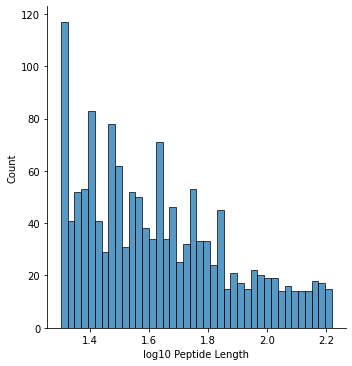

In [30]:
sns.displot(np.log10(klens), bins=40)
plt.xlabel('log10 Peptide Length')
plt.show()

# Done